In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
import shutil
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score

from tqdm import tqdm

In [3]:
torch.manual_seed(1111)
np.random.seed(1111)

In [4]:
images_path = '/content/drive/MyDrive/UP-IIA/Semestre 8/Aprendizaje de Maquina II/FinalProject/'

In [5]:
paths = []
labels = []
data_sets = []

def get_paths_and_labels(folder):
    folder_path = os.path.join(images_path, folder)
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".png") or file.endswith(".jpg"):  # Ajusta la extensión según tus archivos
                file_path = os.path.join(root, file)
                paths.append(file_path)
                labels.append(os.path.basename(os.path.dirname(file_path)))
                data_sets.append(folder)

get_paths_and_labels('train')
get_paths_and_labels('valid')
get_paths_and_labels('test')

df = pd.DataFrame({'filepaths': paths, 'labels': labels, 'data set': data_sets})
df

,filepaths,labels,data set
0,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,Fauvism,train
1,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,Fauvism,train
2,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,Fauvism,train
3,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,Fauvism,train
4,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,Fauvism,train
...,...,...,...
15269,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,Impressionism,test
15270,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,Impressionism,test
15271,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,Impressionism,test
15272,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,Impressionism,test


In [6]:
classes = df["labels"].unique()
num_classes = len(classes)

print(f"Number of classes: {num_classes}")
print(f"Classes: {classes}")

labels = classes.tolist()

numeric_values = list(range(len(labels)))

label_mapping = {}
for label, numeric_value in zip(labels, numeric_values):
    label_mapping[label] = numeric_value

df['labels'] = df['labels'].map(label_mapping)

df

Number of classes: 27
Classes: ['Fauvism' 'Baroque' 'Mannerism_Late_Renaissance' 'Realism'
 'Expressionism' 'Rococo' 'Color_Field_Painting' 'Post_Impressionism'
 'Art_Nouveau_Modern' 'Early_Renaissance' 'Contemporary_Realism' 'Cubism'
 'Pointillism' 'Pop_Art' 'Symbolism' 'Analytical_Cubism'
 'Northern_Renaissance' 'High_Renaissance' 'Minimalism'
 'Abstract_Expressionism' 'Ukiyo_e' 'Romanticism' 'Action_painting'
 'New_Realism' 'Impressionism' 'Naive_Art_Primitivism' 'Synthetic_Cubism']


,filepaths,labels,data set
0,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,0,train
1,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,0,train
2,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,0,train
3,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,0,train
4,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,0,train
...,...,...,...
15269,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,24,test
15270,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,24,test
15271,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,24,test
15272,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,24,test


In [7]:
training_df = pd.DataFrame()
test_df = pd.DataFrame()
val_df = pd.DataFrame()

for label in df['data set'].unique():
    if label == 'train':
        training_df = df[df['data set'] == label]
    elif label == 'test':
        test_df = df[df['data set'] == label]
    elif label == 'valid':
        val_df = df[df['data set'] == label]

print(df.shape[0], ", ", training_df.shape[0] + test_df.shape[0] + val_df.shape[0])

training_df = training_df.drop('data set', axis=1)
test_df = test_df.drop('data set', axis=1)
val_df = val_df.drop('data set', axis=1)

training_df = training_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(training_df)
print(test_df)
print(val_df)

15274 ,  15274
                                               filepaths  labels
0      /content/drive/MyDrive/UP-IIA/Semestre 8/Apren...       0
1      /content/drive/MyDrive/UP-IIA/Semestre 8/Apren...       0
2      /content/drive/MyDrive/UP-IIA/Semestre 8/Apren...       0
3      /content/drive/MyDrive/UP-IIA/Semestre 8/Apren...       0
4      /content/drive/MyDrive/UP-IIA/Semestre 8/Apren...       0
...                                                  ...     ...
13345  /content/drive/MyDrive/UP-IIA/Semestre 8/Apren...      26
13346  /content/drive/MyDrive/UP-IIA/Semestre 8/Apren...      26
13347  /content/drive/MyDrive/UP-IIA/Semestre 8/Apren...      26
13348  /content/drive/MyDrive/UP-IIA/Semestre 8/Apren...      26
13349  /content/drive/MyDrive/UP-IIA/Semestre 8/Apren...      26

[13350 rows x 2 columns]
                                             filepaths  labels
0    /content/drive/MyDrive/UP-IIA/Semestre 8/Apren...      15
1    /content/drive/MyDrive/UP-IIA/Semestre 8/Apren..

In [8]:
training_df

,filepaths,labels
0,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,0
1,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,0
2,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,0
3,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,0
4,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,0
...,...,...
13345,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,26
13346,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,26
13347,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,26
13348,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,26


In [9]:
class MyTrainingDataset(Dataset):
    def __init__(self, df, transform=None):
        self.data = df["filepaths"]  # Assuming your data are filepaths
        self.labels = df['labels']
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = self.data[index]
        img = Image.open(img_path)  # Load the image from the filepath

        if self.transform:
            img = self.transform(img)  # Apply transformations if specified

        label = self.labels[index]
        label = torch.tensor(label, dtype=torch.long)
        return img, label

In [10]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc

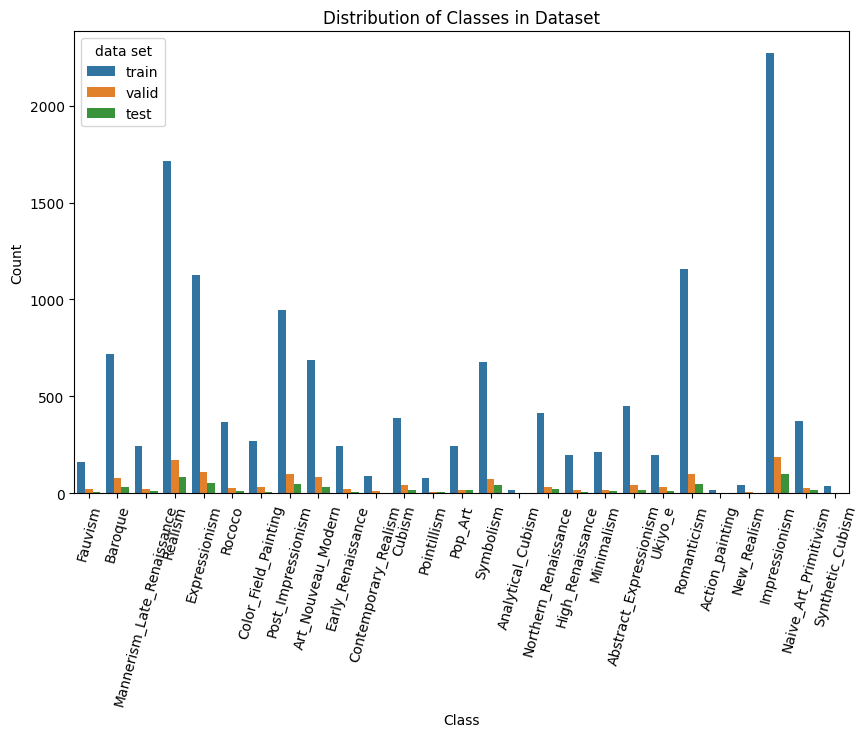

In [ ]:
# Distribución de Clases en el Conjunto de Datos
plt.figure(figsize=(10, 6))
sns.countplot(x=df['labels'].map({v: k for k, v in label_mapping.items()}), hue='data set', data=df)
plt.title('Distribution of Classes in Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=75)
plt.show()

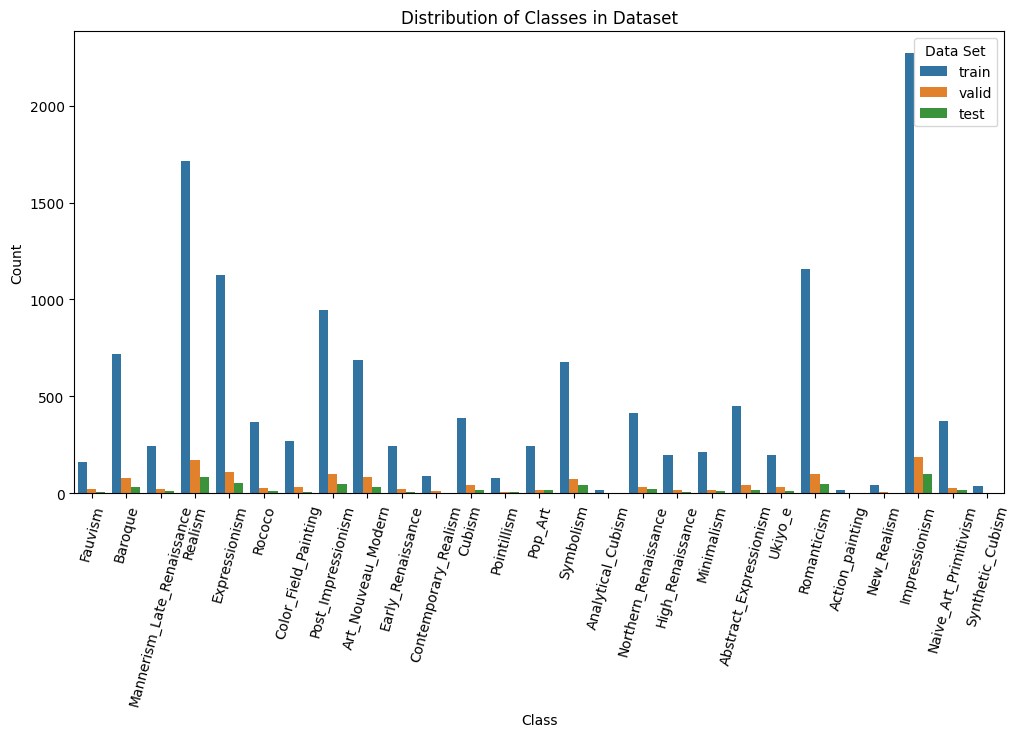

In [ ]:
# Distribución de Clases en el Conjunto de Datos (ampliado)
plt.figure(figsize=(12, 6))
sns.countplot(x=df['labels'].map({v: k for k, v in label_mapping.items()}), hue='data set', data=df)
plt.title('Distribution of Classes in Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=75)
plt.legend(title='Data Set')
plt.show()

In [ ]:
# Frecuencia de Clases en el Conjunto de Datos (entrenamiento, validación, prueba)
train_freq = training_df['labels'].map({v: k for k, v in label_mapping.items()}).value_counts(normalize=True)
val_freq = val_df['labels'].map({v: k for k, v in label_mapping.items()}).value_counts(normalize=True)
test_freq = test_df['labels'].map({v: k for k, v in label_mapping.items()}).value_counts(normalize=True)

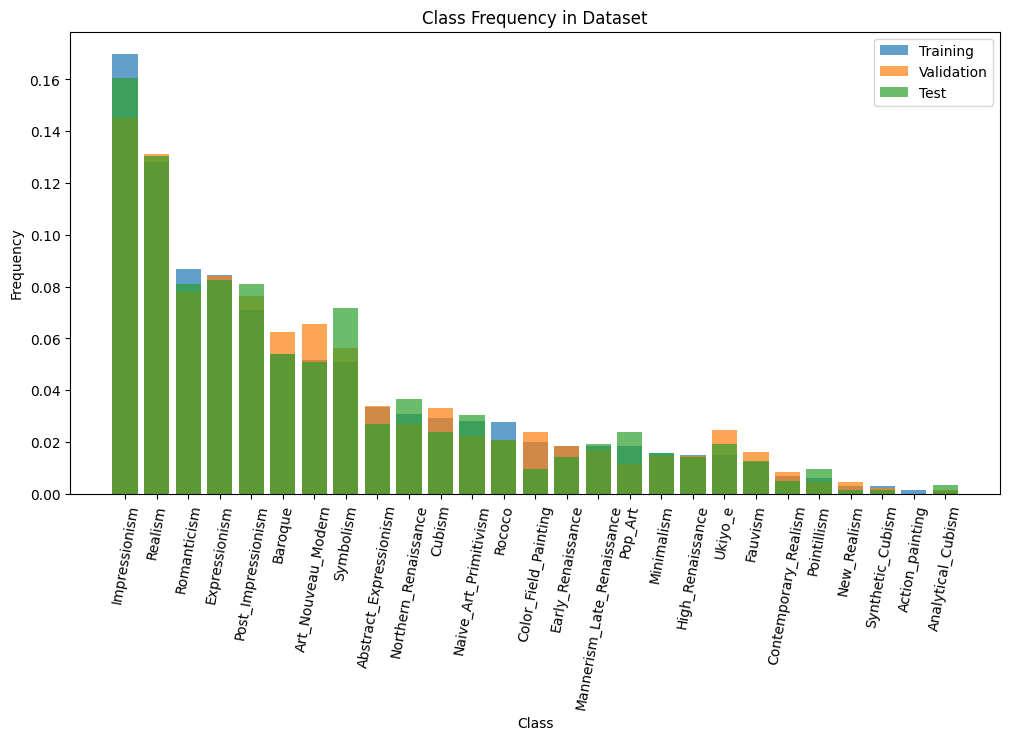

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(train_freq.index, train_freq.values, alpha=0.7, label='Training')
plt.bar(val_freq.index, val_freq.values, alpha=0.7, label='Validation')
plt.bar(test_freq.index, test_freq.values, alpha=0.7, label='Test')
plt.title('Class Frequency in Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=80)
plt.legend()
plt.show()

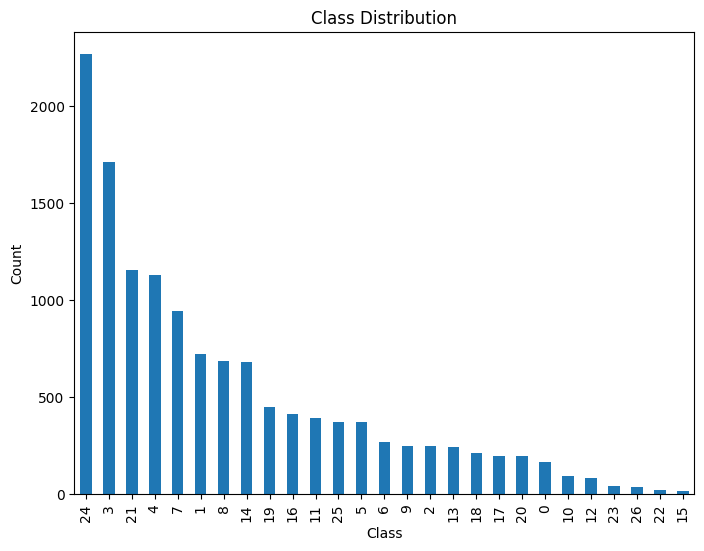

In [ ]:
def plot_class_distribution(dataset):
    plt.figure(figsize=(8, 6))
    dataset['labels'].value_counts().plot(kind='bar')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()

plot_class_distribution(training_df)

# RESNET18

In [11]:
from torchvision.models import resnet18
import torchvision.models as models
import torch.optim as optim

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create an instance of the ResNet18 model
model = resnet18(pretrained=False, num_classes=num_classes)
model = model.to(device)

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [14]:
# Define data augmentation transforms for training images
train_transform = transforms.Compose([
    transforms.Resize((416, 416)),  # Randomly crop the image and resize to 416x416
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(15),  # Randomly rotate the image by up to 15 degrees
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )  # Normalize the tensor
])

# Define the transformations you want to apply to the images
transform = transforms.Compose([
    transforms.Resize((416, 416)),  # Resize images to 416x416
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )  # Normalize the tensor
])

# Create DataLoader instances with data augmentation for training, and without for validation and test datasets
training_dataset = MyTrainingDataset(training_df, transform=train_transform)
training_data_loader = DataLoader(training_dataset, batch_size=36, num_workers=2, shuffle=True)

test_dataset = MyTrainingDataset(test_df, transform=transform)
test_data_loader = DataLoader(test_dataset, batch_size=36, num_workers=2, shuffle=False)

val_dataset = MyTrainingDataset(val_df, transform=transform)
val_data_loader = DataLoader(val_dataset, batch_size=36, num_workers=2, shuffle=False)

In [15]:
test_df

,filepaths,labels
0,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,15
1,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,15
2,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,7
3,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,7
4,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,7
...,...,...
624,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,24
625,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,24
626,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,24
627,/content/drive/MyDrive/UP-IIA/Semestre 8/Apren...,24


In [ ]:
def show_sample_images(dataset, num_images=5):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        img, label = dataset[i]
        label_name = classes[label]  # Obtener el nombre de la categoría desde el diccionario de mapeo de etiquetas
        axs[i].imshow(img.permute(1, 2, 0))
        axs[i].set_title(f'Label: {label_name}')
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

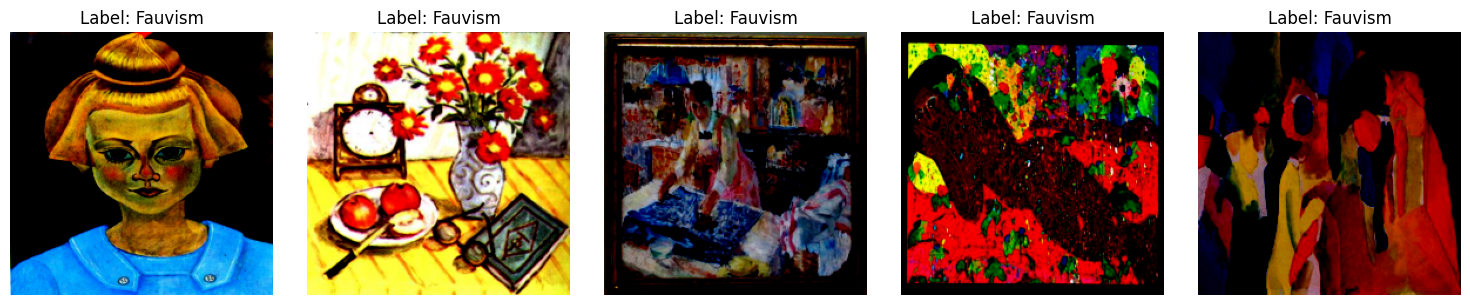

In [ ]:
show_sample_images(MyTrainingDataset(training_df, transform=transform))

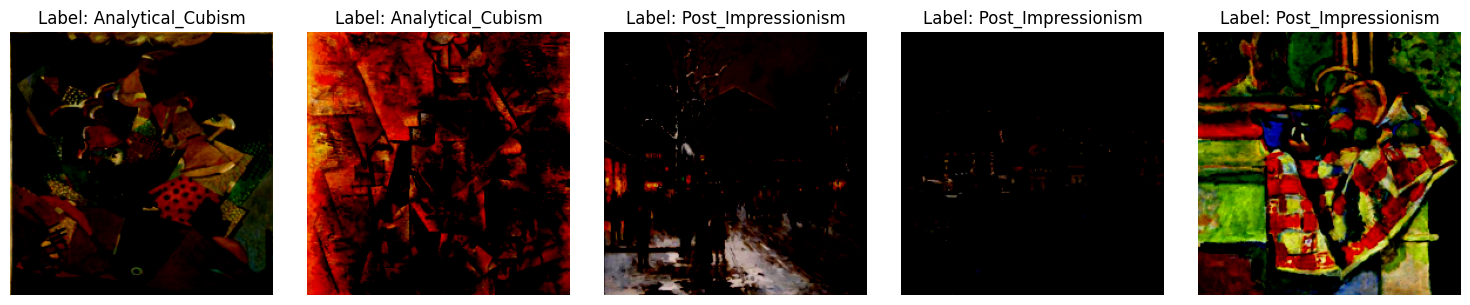

In [ ]:
show_sample_images(MyTrainingDataset(test_df, transform=transform))

## Training RESNET18 with RGB

In [17]:
if not os.path.exists('/content/drive/MyDrive/UP-IIA/Semestre 8/Aprendizaje de Maquina II/FinalProject/models/'):
    os.makedirs('/content/drive/MyDrive/UP-IIA/Semestre 8/Aprendizaje de Maquina II/FinalProject/models/')

num_epochs = 32

loss_history = []
precision_history = []

best_precision = 0.0  # Initialize the best precision
best_model_path = "/content/drive/MyDrive/UP-IIA/Semestre 8/Aprendizaje de Maquina II/FinalProject/models/best_model_resnet18.pth"  # Path to save the best model

In [18]:
# Training loop
for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    all_preds = []
    all_labels = []
    for images, labels in training_data_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

        # Get predictions and true labels for precision calculation
        _, preds = torch.max(outputs, 1)  # Get predicted class indices
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Print the average loss for the current epoch
    epoch_loss = running_loss / len(training_data_loader)
    loss_history.append(epoch_loss)
    precision = precision_score(all_labels, all_preds, average="macro")
    precision_history.append(precision)
    print(f'Epoch [{epoch+1}/{num_epochs}], Precision: {precision:.4f}, loss: {epoch_loss:.4f}')

    # Check if the current precision is better than the previous best
    if precision > best_precision:
        best_precision = precision
        # Save the model
        torch.save(model.state_dict(), best_model_path)

print(f"Best precision achieved: {best_precision:.4f}. Model saved at {best_model_path}")

  0%|          | 0/32 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/32], Precision: 0.0876, loss: 2.7079


  3%|▎         | 1/32 [1:26:06<44:29:27, 5166.68s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  6%|▋         | 2/32 [1:28:46<18:30:35, 2221.20s/it]

Epoch [2/32], Precision: 0.1289, loss: 2.5541


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/32], Precision: 0.1477, loss: 2.4504


  9%|▉         | 3/32 [1:31:25<10:18:32, 1279.74s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 12%|█▎        | 4/32 [1:34:04<6:30:46, 837.36s/it]  

Epoch [4/32], Precision: 0.1725, loss: 2.3775


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 16%|█▌        | 5/32 [1:36:43<4:26:45, 592.78s/it]

Epoch [5/32], Precision: 0.2447, loss: 2.3060


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 19%|█▉        | 6/32 [1:39:23<3:13:04, 445.57s/it]

Epoch [6/32], Precision: 0.2589, loss: 2.2490


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 22%|██▏       | 7/32 [1:42:02<2:26:36, 351.87s/it]

Epoch [7/32], Precision: 0.2444, loss: 2.2048


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 25%|██▌       | 8/32 [1:44:42<1:56:18, 290.76s/it]

Epoch [8/32], Precision: 0.2965, loss: 2.1583


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 28%|██▊       | 9/32 [1:47:21<1:35:39, 249.53s/it]

Epoch [9/32], Precision: 0.2771, loss: 2.1169


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 31%|███▏      | 10/32 [1:50:00<1:21:14, 221.55s/it]

Epoch [10/32], Precision: 0.2948, loss: 2.0747


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 34%|███▍      | 11/32 [1:52:39<1:10:51, 202.46s/it]

Epoch [11/32], Precision: 0.2945, loss: 2.0436


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [12/32], Precision: 0.3067, loss: 1.9977


 38%|███▊      | 12/32 [1:55:18<1:03:05, 189.26s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 41%|████      | 13/32 [1:57:57<57:02, 180.15s/it]  

Epoch [13/32], Precision: 0.3250, loss: 1.9659


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [14/32], Precision: 0.3585, loss: 1.9336


 44%|████▍     | 14/32 [2:00:37<52:11, 173.98s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 47%|████▋     | 15/32 [2:03:17<48:08, 169.92s/it]

Epoch [15/32], Precision: 0.3814, loss: 1.8816


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 50%|█████     | 16/32 [2:05:58<44:33, 167.12s/it]

Epoch [16/32], Precision: 0.3829, loss: 1.8572


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 53%|█████▎    | 17/32 [2:08:39<41:20, 165.35s/it]

Epoch [17/32], Precision: 0.4033, loss: 1.8183


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 56%|█████▋    | 18/32 [2:11:20<38:15, 163.99s/it]

Epoch [18/32], Precision: 0.4072, loss: 1.7882


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 59%|█████▉    | 19/32 [2:14:01<35:20, 163.12s/it]

Epoch [19/32], Precision: 0.4268, loss: 1.7312


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 62%|██████▎   | 20/32 [2:16:41<32:27, 162.26s/it]

Epoch [20/32], Precision: 0.4665, loss: 1.6965


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 66%|██████▌   | 21/32 [2:19:23<29:44, 162.21s/it]

Epoch [21/32], Precision: 0.4828, loss: 1.6601


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 69%|██████▉   | 22/32 [2:22:04<26:57, 161.79s/it]

Epoch [22/32], Precision: 0.4827, loss: 1.6132


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 72%|███████▏  | 23/32 [2:24:45<24:12, 161.43s/it]

Epoch [23/32], Precision: 0.5010, loss: 1.5758


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 75%|███████▌  | 24/32 [2:27:25<21:27, 160.98s/it]

Epoch [24/32], Precision: 0.5205, loss: 1.5291


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [25/32], Precision: 0.5224, loss: 1.4904


 78%|███████▊  | 25/32 [2:30:06<18:46, 160.97s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 81%|████████▏ | 26/32 [2:32:46<16:05, 160.85s/it]

Epoch [26/32], Precision: 0.5010, loss: 1.4632


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 84%|████████▍ | 27/32 [2:35:27<13:24, 160.85s/it]

Epoch [27/32], Precision: 0.5493, loss: 1.3970


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 88%|████████▊ | 28/32 [2:38:08<10:42, 160.71s/it]

Epoch [28/32], Precision: 0.5377, loss: 1.3538


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [29/32], Precision: 0.5649, loss: 1.3046


 91%|█████████ | 29/32 [2:40:48<08:01, 160.49s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 94%|█████████▍| 30/32 [2:43:27<05:20, 160.32s/it]

Epoch [30/32], Precision: 0.5803, loss: 1.2676


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 97%|█████████▋| 31/32 [2:46:07<02:39, 159.96s/it]

Epoch [31/32], Precision: 0.6007, loss: 1.2100


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 32/32 [2:48:47<00:00, 316.49s/it]

Epoch [32/32], Precision: 0.6371, loss: 1.1658
Best precision achieved: 0.6371. Model saved at /content/drive/MyDrive/UP-IIA/Semestre 8/Aprendizaje de Maquina II/FinalProject/models/best_model_resnet18.pth


In [19]:
best_model_resnet18 = models.resnet18(pretrained=False)

best_model_resnet18.fc = torch.nn.Linear(best_model_resnet18.fc.in_features, num_classes)

best_model_resnet18.load_state_dict(torch.load(best_model_path))

best_model_resnet18.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

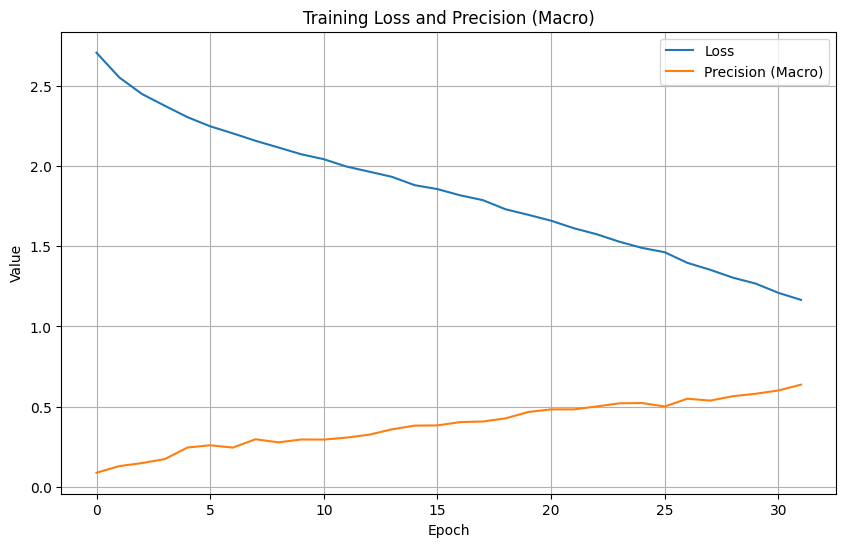

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(loss_history)), loss_history, label='Loss')
plt.plot(range(len(precision_history)), precision_history, label='Precision (Macro)')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Precision (Macro)')
plt.legend()
plt.grid(True)
plt.show()

  0%|          | 0/18 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 18/18 [04:38<00:00, 15.47s/it]


Accuracy: 0.3196
F1-score: 0.2289


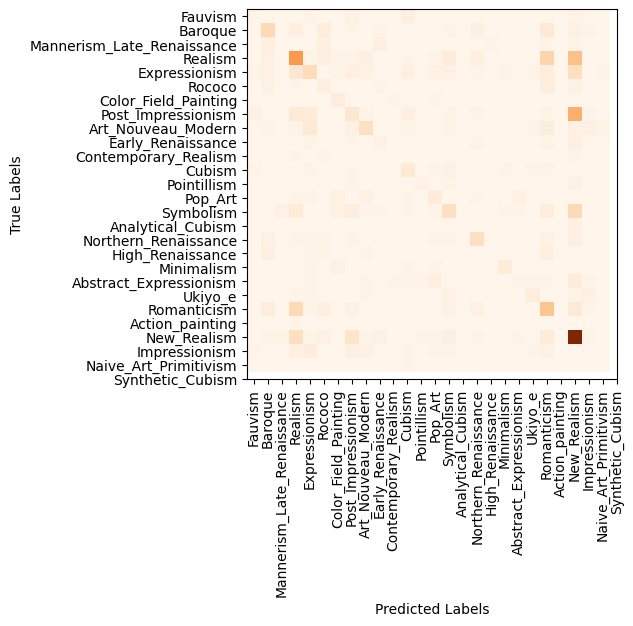

In [21]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model_resnet18.to(device)

predictions = []
true_labels = []

# Disable gradient calculation and use torch.no_grad() to speed up computation
with torch.no_grad():
    # Iterate test data loader
    for images, labels in tqdm(test_data_loader, total=len(test_data_loader)):
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model
        outputs = best_model_resnet18(images)

        # Compute predictions by taking the argmax of the output scores
        _, preds = torch.max(outputs, 1)

        # Convert predictions and labels to numpy arrays and store them
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate accuracy and F1-score
test_accuracy = accuracy_score(true_labels, predictions)
test_f1 = f1_score(true_labels, predictions, average='macro')

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Print accuracy and F1-score
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1-score: {test_f1:.4f}")

# Visualize confusion matrix
plt.imshow(conf_matrix, cmap="Oranges")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(np.arange(num_classes), classes, rotation=90)
plt.yticks(np.arange(num_classes), classes)
plt.show()

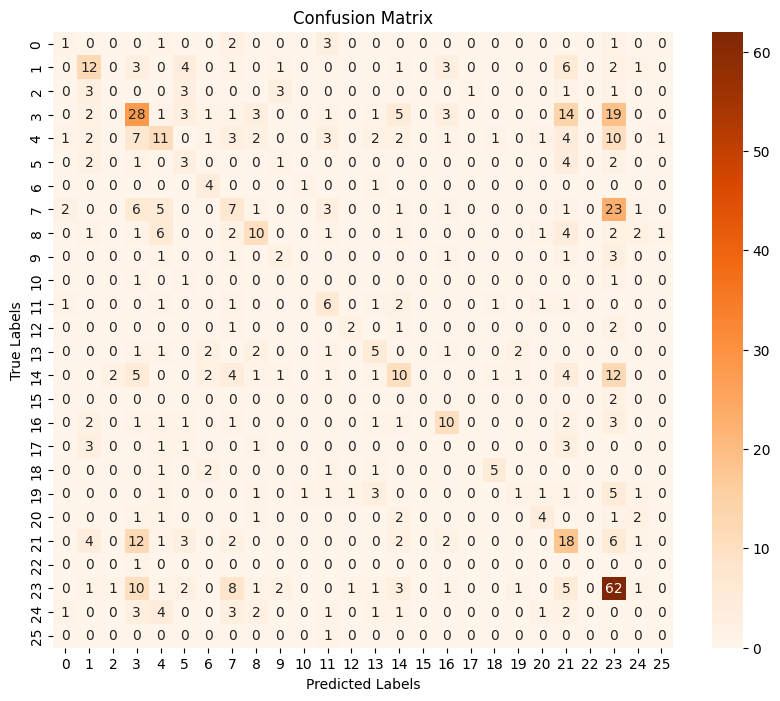

In [22]:
# Matriz de Confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Oranges")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

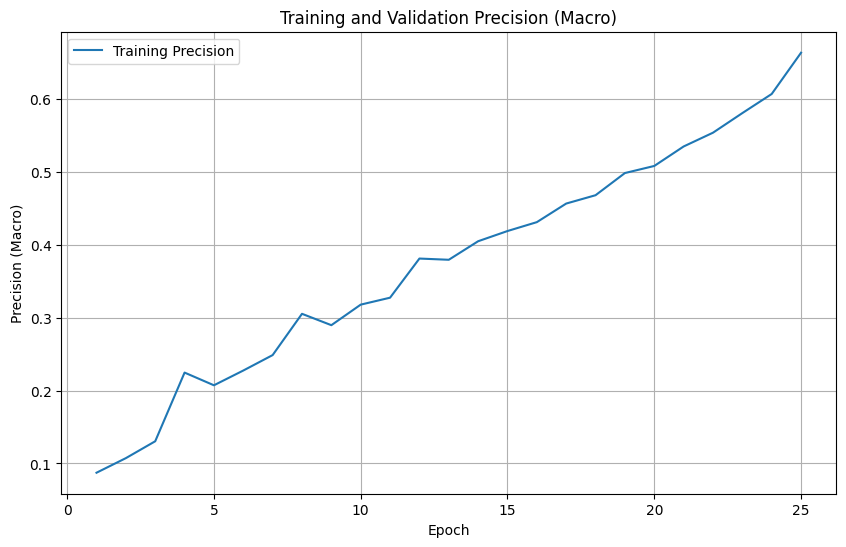

In [ ]:
# Comparación de Precisiones en Entrenamiento y Validación
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), precision_history, label='Training Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision (Macro)')
plt.title('Training and Validation Precision (Macro)')
plt.legend()
plt.grid(True)
plt.show()

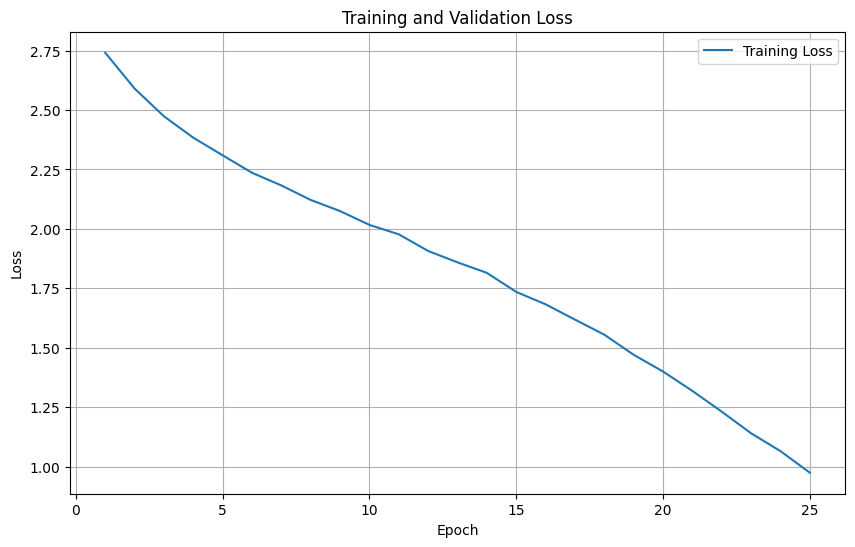

In [ ]:
# Comparación de Pérdidas en Entrenamiento y Validación
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


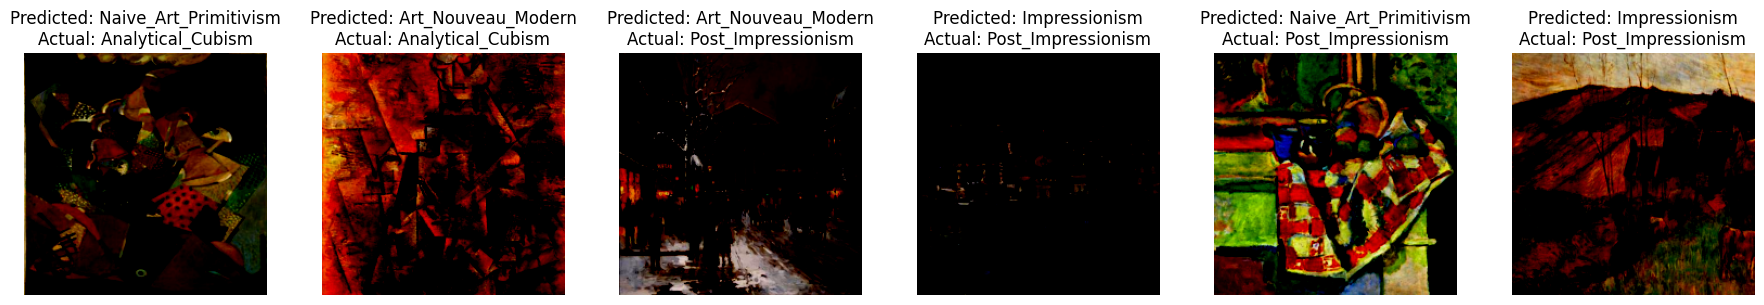

In [ ]:
# Visualización de Predicciones Incorrectas
def visualize_incorrect_predictions(model, data_loader):
    model.eval()
    incorrect_samples = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    incorrect_samples.append((images[i].cpu(), predicted[i].cpu().item(), labels[i].cpu().item()))
                    if len(incorrect_samples) >= 6:
                        break
                if len(incorrect_samples) >= 6:
                    break
    plt.figure(figsize=(18, 3))
    for i, (image, predicted, label) in enumerate(incorrect_samples):
        if i >= 6:  # Salir después de procesar 5 imágenes incorrectas
          break
        plt.subplot(1, 6, i+1)
        plt.imshow(image.permute(1, 2, 0).numpy())
        predicted_name = classes[predicted]
        actual_name = classes[label]
        plt.title(f'Predicted: {predicted_name}\nActual: {actual_name}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_incorrect_predictions(model, test_data_loader)

100%|██████████| 18/18 [00:04<00:00,  4.42it/s]


Accuracy: 0.2862
F1-score: 0.2177


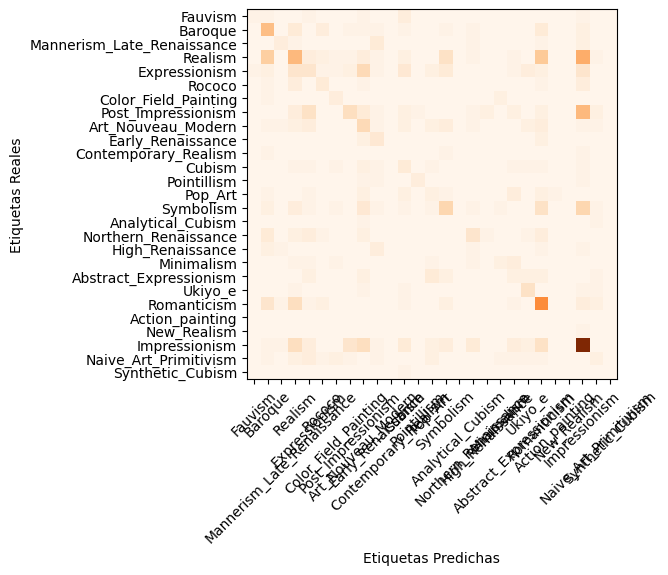

In [ ]:
all_preds = []
all_labels = []
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_data_loader, total=len(test_data_loader)):
        images, labels = images.to(device), labels.to(device)
        outputs = best_model_resnet18(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Almacenar predicciones y etiquetas
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds, average='macro')

# Calcular y visualizar la matriz de confusión
confusion_matrix = confusion_matrix(true_labels, predictions)
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1-score: {test_f1:.4f}")

plt.imshow(confusion_matrix, cmap="Oranges")
plt.xlabel("Etiquetas Predichas")
plt.ylabel("Etiquetas Reales")
plt.xticks(np.arange(num_classes), classes, rotation=45)
plt.yticks(np.arange(num_classes), classes)
plt.show()

Transfer Learning

IT DOES NOT WORK


In [ ]:
# model = models.resnet18(pretrained=True)

In [ ]:
# for param in model.parameters():
#     param.requires_grad = False  # Freeze all parameters


In [ ]:
# num_features_in = model.fc.in_features  # Get the number of input features from the existing FC layer
# model.fc = nn.Sequential(
#     nn.Linear(num_features_in, num_classes),  # New FC layer for 30 classes
#     nn.Softmax(dim=1)  # Apply softmax activation for probability output
# )
# model.to(device)

In [ ]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# directory_path ='/content/drive/MyDrive/Emiliano/UP/Paper/images/'
# dataset = MyTrainingDataset(training_df, directory_path, transform=transform)
# data_loader = DataLoader(dataset, batch_size=36, num_workers=2, shuffle=True)

In [ ]:
# num_epochs = 15

# loss_history = []
# precision_history = []
# # Training loop
# for epoch in range(num_epochs):
#     running_loss = 0.0
#     all_preds = []
#     all_labels = []
#     for images, labels in (data_loader):
#         images = images.to(device)
#         labels = labels.to(device)

#         # Zero out the gradients
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = model(images)
#         loss = criterion(outputs, labels)

#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()

#         # Accumulate the loss
#         running_loss += loss.item()

#         # Get predictions and true labels for precision calculation
#         _, preds = torch.max(outputs, 1)  # Get predicted class indices
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

#     # Print the average loss for the current epoch
#     epoch_loss = running_loss / len(data_loader)
#     loss_history.append(epoch_loss)
#     precision = precision_score(all_labels, all_preds, average="macro")
#     precision_history.append(precision)
#     print(f'Epoch [{epoch+1}/{num_epochs}], Precision: {precision:.4f}')

Why tranfer learning does not work?

You can see at the categories of the model and they are not related with musical instruments


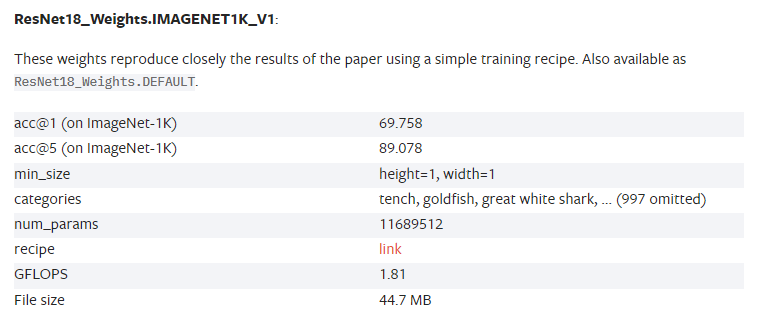


## Training RESNET18 with grayscale

In [ ]:
def convert_rgb_to_grayscale(img):
    if img.mode == 'RGB':  # Check if it's RGB
        return img.convert('L')  # Convertir a escala de grises
    else:
        return img  # Ya está en escala de grises

In [ ]:
class MyTrainingDatasetGray(Dataset):
    def __init__(self, df, transform=None):
        self.data = df["filepaths"]  # Assuming your data are filepaths
        self.labels = df['labels']
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = self.data[index]
        img = Image.open(img_path)  # Load the image from the filepath

        img = convert_rgb_to_grayscale(img)

        if self.transform:
            img = self.transform(img)  # Apply transformations if specified

        label = self.labels[index]
        label = torch.tensor(label, dtype=torch.long)
        return img, label

In [ ]:
# Create an instance of the ResNet18 model
model = resnet18(pretrained=False, num_classes=num_classes)
model = model.to(device)

In [ ]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# # Define the transformations you want to apply to the images
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize images to 224x224
#     transforms.ToTensor(),  # Convert to PyTorch tensor
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )  # Normalize the tensor
# ])

# dataset = MyTrainingDataset(training_df, images_path, transform=transform)
# training_data_loader = DataLoader(dataset, batch_size=36, num_workers=2, shuffle=True)

# dataset = MyTrainingDataset(test_df, images_path, transform=transform)
# test_data_loader = DataLoader(dataset, batch_size=36, num_workers=2, shuffle=True)

# dataset = MyTrainingDataset(val_df, images_path, transform=transform)
# val_data_loader = DataLoader(dataset, batch_size=36, num_workers=2, shuffle=True)

In [ ]:
import torch
from sklearn.metrics import precision_score
from tqdm import tqdm

num_epochs = 20

loss_history = []
precision_history = []

best_precision = 0.0  # Initialize the best precision
best_model_path = "models/best_model_resnet18_grayscale.pth"  # Path to save the best model

# Training loop
for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    all_preds = []
    all_labels = []
    for images, labels in training_data_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

        # Get predictions and true labels for precision calculation
        _, preds = torch.max(outputs, 1)  # Get predicted class indices
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Print the average loss for the current epoch
    epoch_loss = running_loss / len(training_data_loader)
    loss_history.append(epoch_loss)
    precision = precision_score(all_labels, all_preds, average="macro")
    precision_history.append(precision)
    print(f'Epoch [{epoch+1}/{num_epochs}], Precision: {precision:.4f}, loss: {epoch_loss:.4f}')

    # Check if the current precision is better than the previous best
    if precision > best_precision:
        best_precision = precision
        # Save the model
        torch.save(model.state_dict(), best_model_path)

print(f"Best precision achieved: {best_precision:.4f}. Model saved at {best_model_path}")

In [ ]:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Plot loss history
plt.plot(range(len(loss_history)), loss_history, label='Loss')

# Plot precision history
plt.plot(range(len(precision_history)), precision_history, label='Precision (Macro)')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Precision (Macro)')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [ ]:
best_model_resnet18_grayscale.load_state_dict(torch.load(best_model_path))

best_model_resnet18_grayscale.eval()

In [ ]:
all_preds = []
all_labels = []
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_data_loader, total=len(test_data_loader)):
        images, labels = images.to(device), labels.to(device)
        outputs = best_model_resnet18_rgb(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Almacenar predicciones y etiquetas
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds, average='macro')

# Calcular y visualizar la matriz de confusión
confusion_matrix = confusion_matrix(true_labels, predictions)
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1-score: {test_f1:.4f}")

plt.imshow(confusion_matrix, cmap="Oranges")
plt.xlabel("Etiquetas Predichas")
plt.ylabel("Etiquetas Reales")
plt.xticks(np.arange(num_classes), classes, rotation=45)
plt.yticks(np.arange(num_classes), classes)
plt.show()